In [1]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from kooplearn.models import Kernel, NystroemKernel
from klearn_tcyclone.kooplearn.models.nystroem import NystroemKernelCustom

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series

from kooplearn.utils import topk

from klearn_tcyclone.climada.tc_tracks_tools import BASINS

from klearn_tcyclone.utils import check_time_steps_TCTracks
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling, slide_by_scaling, get_top_k_ev_below_zero, train_model
from klearn_tcyclone.climada.utils import get_TCTrack_dict

from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling

In [2]:
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="official", year_range=(2000, 2021), basin="EP"
)

c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-11-23 09:00:03,571 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-11-23 09:01:15,735 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 2000187N12245, 2000201N11224, 2000203N17249, 2000228N31180.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


In [28]:
context_length = 12
time_lag = 1
feature_list = ['lon', 'lat', 'max_sustained_wind', 'radius_max_wind', 'radius_oci', 'central_pressure', 'environmental_pressure']

In [29]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    context_length=context_length,
    time_lag=time_lag,
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test,
    feature_list=feature_list,
    context_length=context_length,
    time_lag=time_lag,
)
contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [30]:
contexts["train"].shape

(16749, 12, 7)

In [31]:
tcd = contexts["train"]

In [32]:
from kooplearn.data import TensorContextDataset, TrajectoryContextDataset
from numpy.typing import NDArray

def periodic_identification(x, limit_min, limit_max):
    dist = limit_max - limit_min
    if x >= limit_max:
        x = x - dist
    if x < limit_min:
        x = x + dist
    return x

periodic_identification = np.vectorize(periodic_identification, excluded=["limit_min", "limit_max"])


def periodic_shift(
    data: NDArray,
    shift: float,
    dim: int,
    limits: tuple[float, float],
):
    data_c = data.copy()
    data_c[:,:,dim] = data_c[:,:,dim] + shift
    data_c[:,:,dim] = periodic_identification(data_c[:,:,dim], limit_min=limits[0], limit_max=limits[1])
    return data_c

# def shift_latitude_TensorContextDataset(
#     tensor_context_dataset,
#     latitude: float,
#     backend: str = "auto",
#     **backend_kw,
# ):
#     data = tensor_context_dataset.data.copy()
#     data[:,:,0] = data[:,:,0] + latitude
    
#     tensor_context_dataset_shifted = TensorContextDataset(
#         data, backend, **backend_kw
#     )

#     return tensor_context_dataset_shifted

In [39]:
data = tcd.data.copy()

shift = 60
data_new = periodic_shift(data, shift=shift, dim = 0, limits=(-180, 180))
# data_new = periodic_shift(data, shift=shift, dim = 1, limits=(-90, 90))

In [40]:
data.shape, data_new.shape

((16749, 12, 7), (16749, 12, 7))

In [41]:
cmap1 = plt.cm.coolwarm
cmap2 = plt.cm.Greens

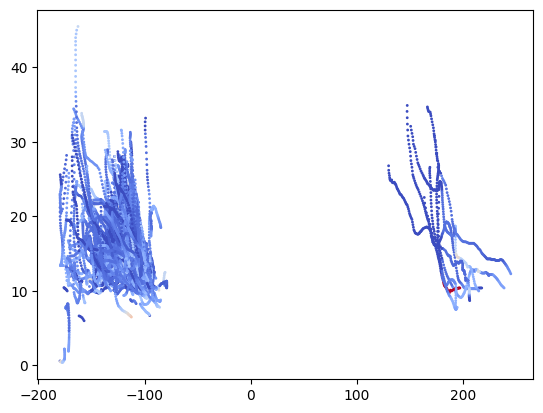

In [42]:
plt.scatter(data[:,0,0], data[:, 0, 1], c=data[:,0,3], cmap=cmap1, s=1)

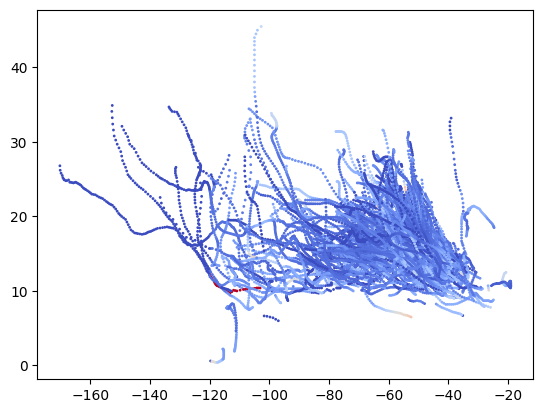

In [43]:
plt.scatter(data_new[:,0,0], data_new[:, 0, 1], c=data_new[:,0,3], cmap=cmap1, s=1)

In [12]:
x_space = np.linspace(0, 1, 20)
data = np.array(
    [
        [
            x_space,
            x_space**2,
            1 + x_space**3,
            1 + x_space**4,
        ],
        [
            x_space,
            1 + x_space**2,
            2 + x_space**3,
            2 + x_space**4,
        ],
    ]
).transpose((0,2,1))

In [13]:
data.shape

(2, 20, 4)

In [14]:
shift = 0.25
data_new = periodic_shift(data, shift=shift, dim = 0, limits=(0, 1))
# data_new = periodic_shift(data, shift=shift, dim = 1, limits=(-90, 90))

In [15]:
data.shape, data_new.shape

((2, 20, 4), (2, 20, 4))

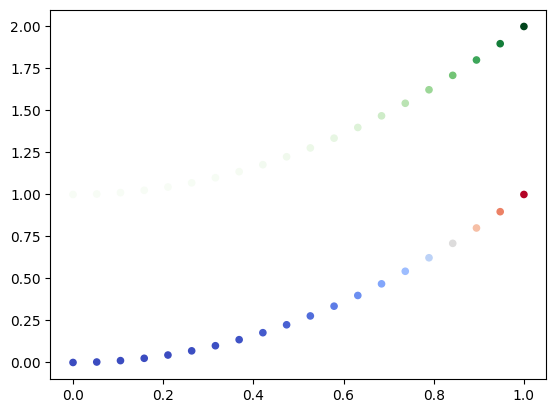

In [17]:
plt.scatter(data[0,:,0], data[0, :, 1], c=data[0,:,3], cmap=cmap1, s=20)
plt.scatter(data[1,:,0], data[1, :, 1], c=data[1,:,3], cmap=cmap2, s=20)

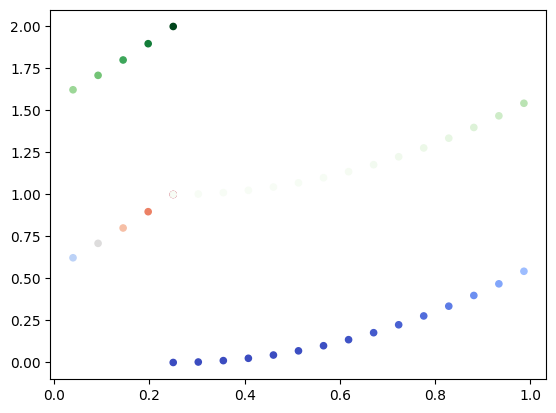

In [18]:
plt.scatter(data_new[0,:,0], data_new[0, :, 1], c=data_new[0,:,3], cmap=cmap1, s=20)
plt.scatter(data_new[1,:,0], data_new[1, :, 1], c=data_new[1,:,3], cmap=cmap2, s=20)